In [93]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
%matplotlib inline

In [31]:
vr = pd.read_csv('../input/video_review.csv')
pprd = pd.read_csv('../input/play_player_role_data.csv')
vr_merged = pd.merge(pd.merge(vr, pprd), pprd, left_on=['Season_Year','GameKey','PlayID','Primary_Partner_GSISID'],
                                   right_on=['Season_Year','GameKey','PlayID','GSISID'], how='left').fillna('None')

In [32]:
vr_merged.loc[(vr['Season_Year'] == 2017) &
       (vr['GameKey'] == 553)]

,Season_Year,GameKey,PlayID,GSISID_x,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire,Role_x,GSISID_y,Role_y
30,2017,553,1683,32820,Blocking,No,Helmet-to-helmet,25503,Blocked,No,PDL2,25503,PLS


In [83]:
play =pd.read_csv('../working/playlevel/during_play/2017-553-1683.csv')
play['xy'] = play['x'].astype(str) + ',' + play['y'].astype(str)
play_pivoted = play.pivot(index='time', columns='role', values=['xy','mph','dir', 'x', 'y'])
play_pivoted.columns = [' '.join(col).strip() for col in play_pivoted.columns.values]

In [84]:
mph_cols = [col for col in play_pivoted.columns if col[:3] == 'mph']

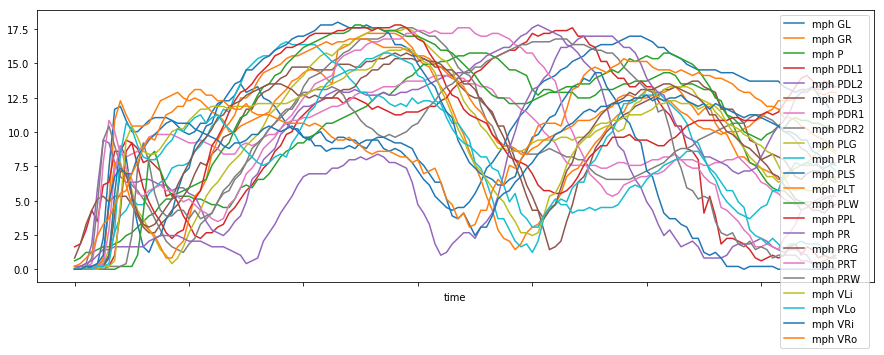

In [85]:
play_pivoted[mph_cols].plot(figsize=(15, 5))

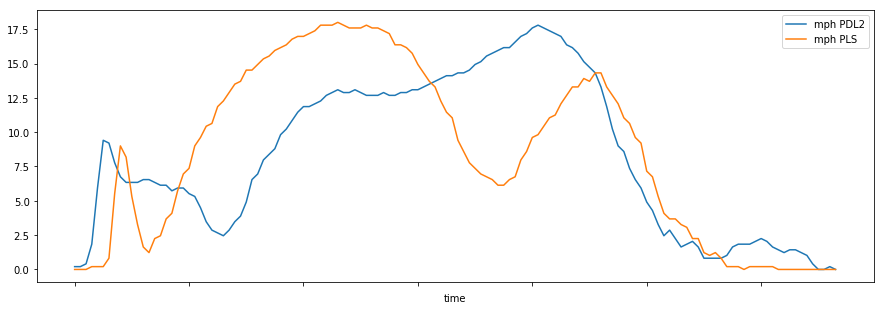

In [86]:
play_pivoted[['mph PDL2','mph PLS']].plot(figsize=(15, 5))

## Euclidian distance

In [123]:
play_pivoted['PDL2-PLS-distance'] = np.sqrt(np.square(play_pivoted['x PDL2'].astype('float') - play_pivoted['x PLS'].astype('float')) + np.square(play_pivoted['y PDL2'].astype('float') - play_pivoted['y PLS'].astype('float')))

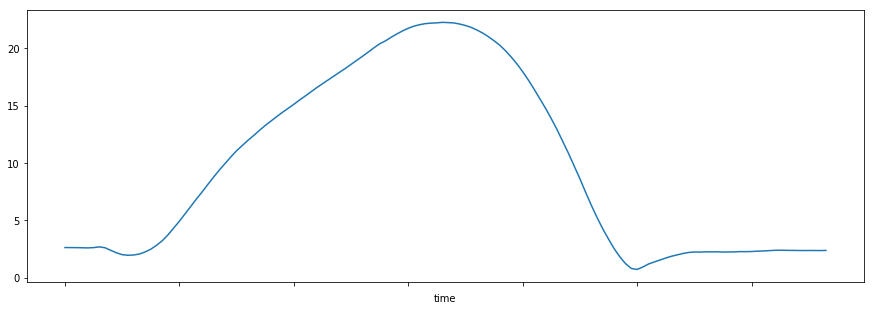

In [125]:
play_pivoted['PDL2-PLS-distance'].plot(figsize=(15, 5))

## Find the Time of the hit

In [131]:
min_distance_time = play_pivoted['PDL2-PLS-distance'].sort_values().index[0]

In [132]:
min_distance_time

'2017-11-19 19:16:21.700'

In [141]:
play_pivoted.loc[min_distance_time][['dir PDL2','dir PLS','PDL2-PLS-distance','mph PDL2', 'mph PLS']]

dir PDL2               264.42
dir PLS                 21.63
PDL2-PLS-distance    0.718471
mph PDL2              4.90909
mph PLS               7.15909
Name: 2017-11-19 19:16:21.700, dtype: object

In [140]:
import numpy as np

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [158]:
play_pivoted['PDL2_x_force'], play_pivoted['PDL2_y_force'] = pol2cart(play_pivoted['mph PDL2'].astype('float'), play_pivoted['dir PDL2'].astype('float') * (np.pi/ 180))
play_pivoted['PLS_x_force'], play_pivoted['PLS_y_force'] = pol2cart(play_pivoted['mph PLS'].astype('float'), play_pivoted['dir PLS'].astype('float') * (np.pi/ 180))

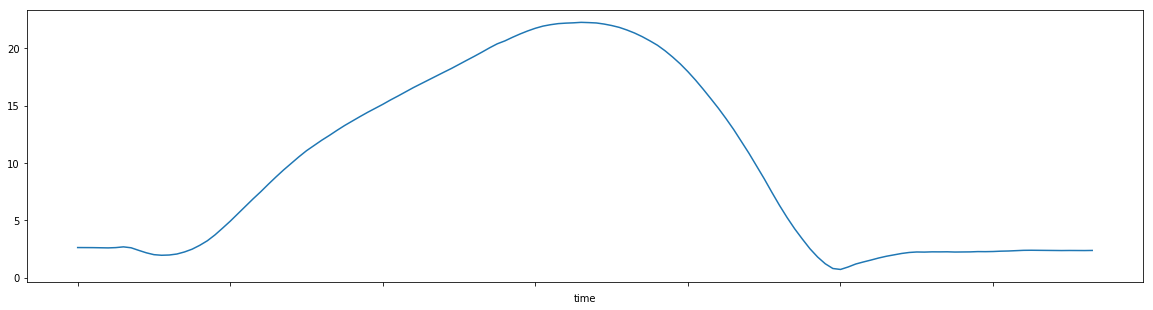

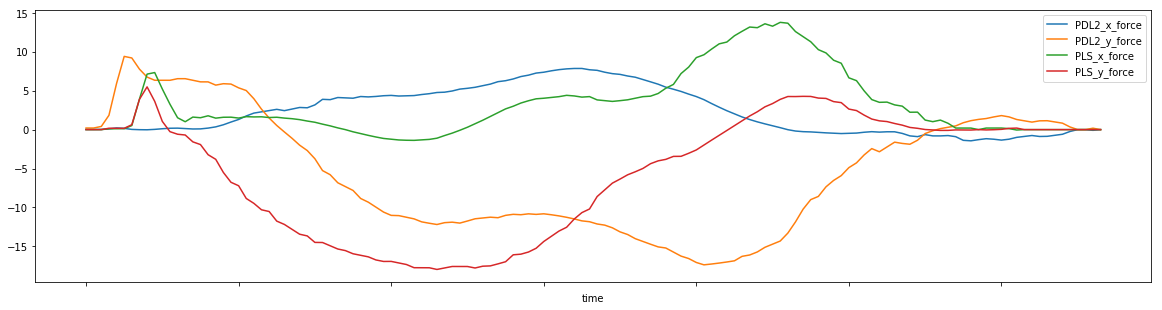

In [161]:
play_pivoted['PDL2-PLS-distance'].plot(figsize=(20, 5))
play_pivoted[['PDL2_x_force','PDL2_y_force','PLS_x_force','PLS_y_force']].sort_index().plot(figsize=(20, 5))

In [173]:
play_pivoted['PLS_PDL2_Opposing_Forces'] = np.sqrt(np.square(play_pivoted['PDL2_x_force'] \
                  - play_pivoted['PLS_x_force']) + \
        np.square((play_pivoted['PDL2_y_force'] - \
                   play_pivoted['PLS_y_force'])))

Timestamp('2017-11-19 19:16:21.700000')

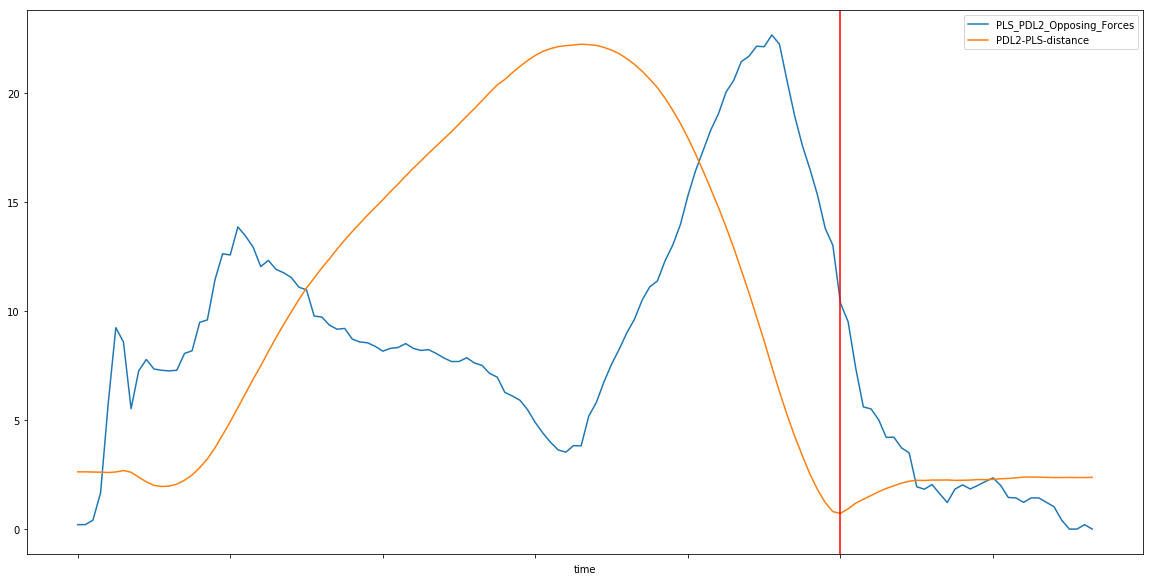

In [198]:
play_pivoted[['PLS_PDL2_Opposing_Forces','PDL2-PLS-distance']].plot(figsize=(20, 10))
plt.axvline(100, color='red')

## Try for a second play

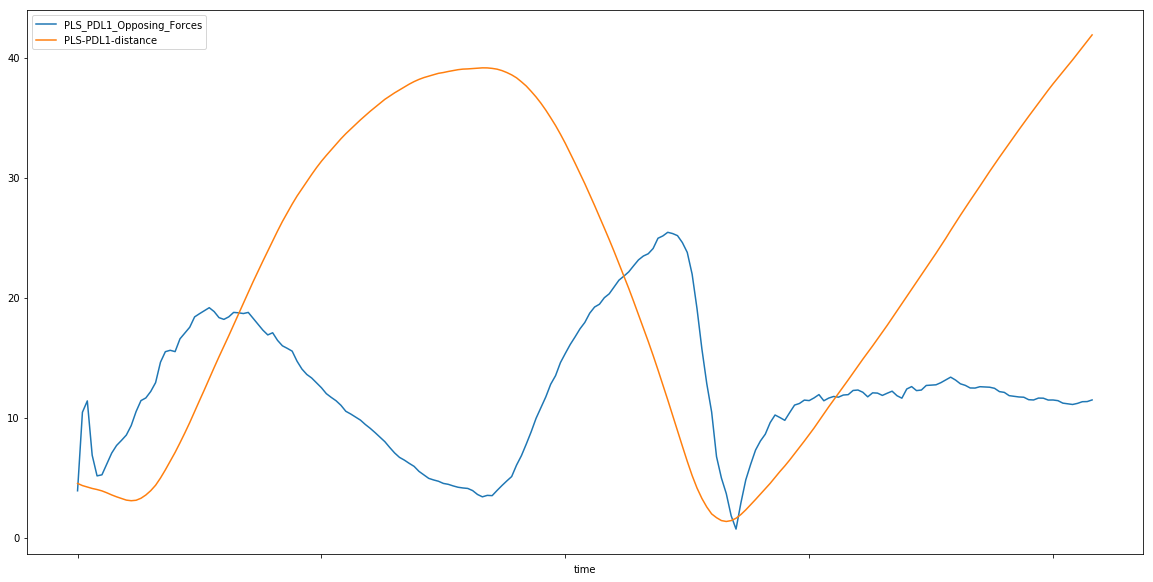

In [207]:
def plot_opposing_forces(year, gamekey, playid, role1, role2):
    play = pd.read_csv(
        '../working/playlevel/during_play/{}-{}-{}.csv'.format(year, gamekey, playid))
    play['xy'] = play['x'].astype(str) + ',' + play['y'].astype(str)
    play_pivoted = play.pivot(index='time', columns='role', values=[
                              'xy', 'mph', 'dir', 'x', 'y'])
    play_pivoted.columns = [' '.join(col).strip()
                            for col in play_pivoted.columns.values]
    play_pivoted['{}-{}-distance'.format(role1, role2)] = \
        np.sqrt(np.square(play_pivoted['x {}'.format(role1)].astype('float')
                          - play_pivoted['x {}'.format(role2)].astype('float'))
                + np.square(play_pivoted['y {}'.format(role1)].astype('float') \
                            - play_pivoted['y {}'.format(role2)].astype('float')))
    play_pivoted['{}_x_force'.format(role1)], play_pivoted['{}_y_force'.format(role1)] = pol2cart(
        play_pivoted['mph {}'.format(role1)].astype('float'), play_pivoted['dir {}'.format(role1)].astype('float') * (np.pi / 180))
    play_pivoted['{}_x_force'.format(role2)], play_pivoted['{}_y_force'.format(role2)] = pol2cart(
        play_pivoted['mph {}'.format(role2)].astype('float'), play_pivoted['dir {}'.format(role2)].astype('float') * (np.pi / 180))
    
    play_pivoted['{}_{}_Opposing_Forces'.format(role1, role2)] = np.sqrt(np.square(play_pivoted['{}_x_force'.format(role1)] \
                  - play_pivoted['{}_x_force'.format(role2)]) + \
        np.square((play_pivoted['{}_y_force'.format(role1)] - \
                   play_pivoted['{}_y_force'.format(role2)])))
    
    play_pivoted[['{}_{}_Opposing_Forces'.format(role1, role2),
                  '{}-{}-distance'.format(role1, role2)]].plot(figsize=(20, 10))
    return play_pivoted

df = plot_opposing_forces(2017, 392, 1088, 'PLS', 'PDL1')

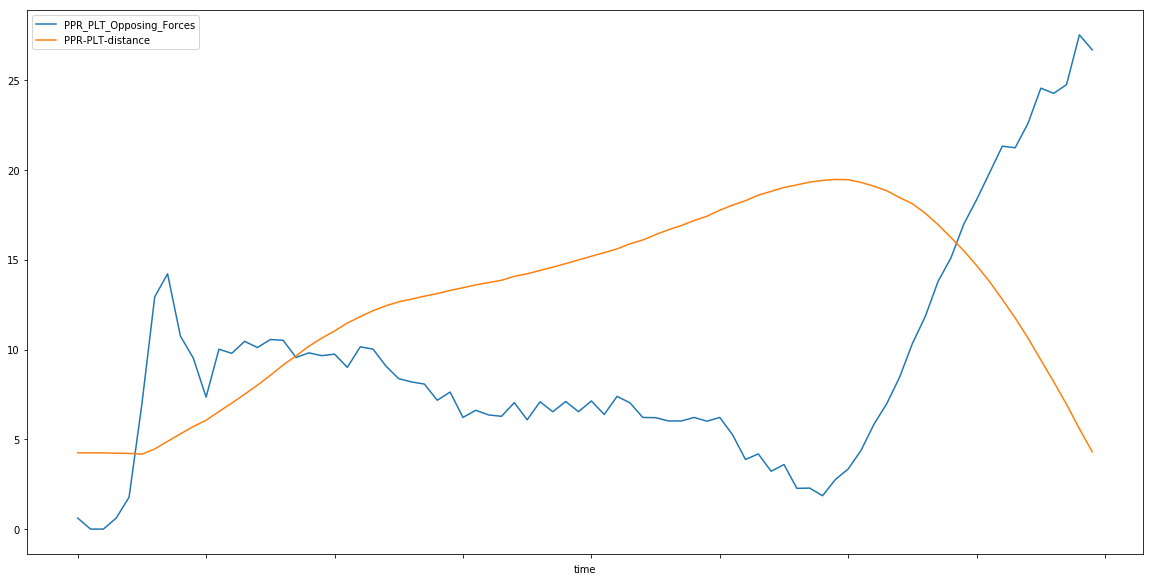

In [211]:
df = plot_opposing_forces(2017, 384, 183, 'PPR', 'PLT')

3129
time
2016-08-12 02:07:47.500    20.268465
2016-08-12 02:07:47.600    20.087118
2016-08-12 02:07:47.700    20.674982
2016-08-12 02:07:47.800    17.001359
Name: PLW_PR_Opposing_Forces, dtype: float64


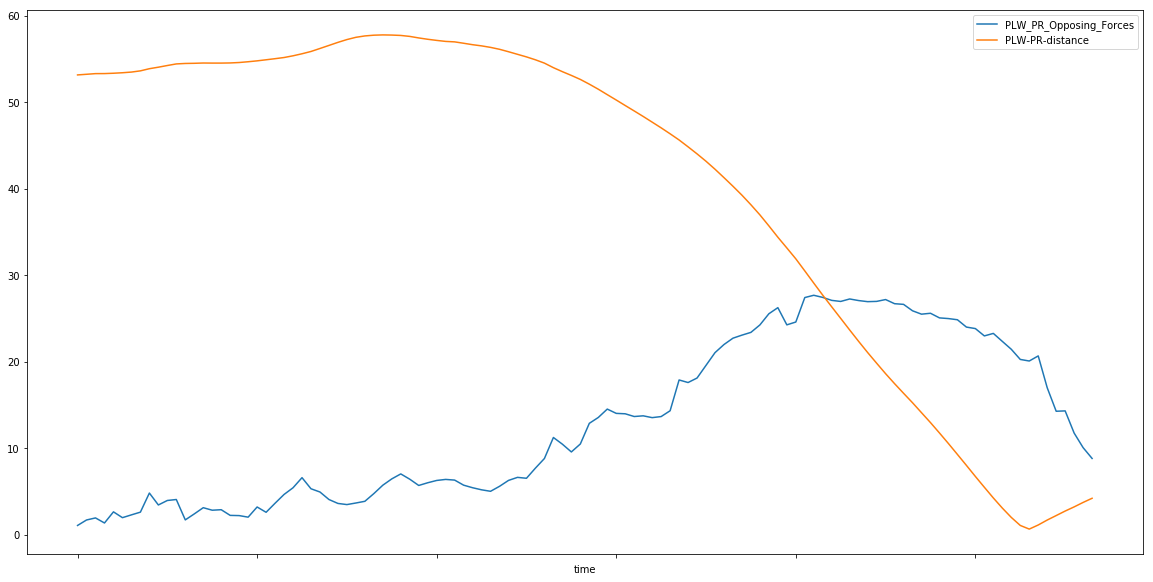

2587
time
2016-08-20 21:04:14.100    7.531728
2016-08-20 21:04:14.200    7.167434
2016-08-20 21:04:14.300    5.802324
2016-08-20 21:04:14.400    4.792958
2016-08-20 21:04:14.500    4.878996
2016-08-20 21:04:14.600    3.940851
2016-08-20 21:04:14.700    2.675086
2016-08-20 21:04:14.800    2.267225
2016-08-20 21:04:14.900    2.479479
2016-08-20 21:04:15.000    1.821513
2016-08-20 21:04:15.100    1.109849
2016-08-20 21:04:15.200    0.896045
2016-08-20 21:04:15.300    1.166415
2016-08-20 21:04:15.400    1.091391
2016-08-20 21:04:15.500    0.337009
2016-08-20 21:04:15.600    1.261534
2016-08-20 21:04:15.700    0.523107
2016-08-20 21:04:15.800    0.662381
2016-08-20 21:04:15.900    0.616429
2016-08-20 21:04:16.000    1.281653
2016-08-20 21:04:16.100    3.511130
2016-08-20 21:04:16.200    3.929668
2016-08-20 21:04:16.300    4.458895
2016-08-20 21:04:16.400    5.128865
2016-08-20 21:04:16.500    6.634784
2016-08-20 21:04:16.600    6.306714
2016-08-20 21:04:16.700    5.726093
Name: GL_PLL1_Oppo

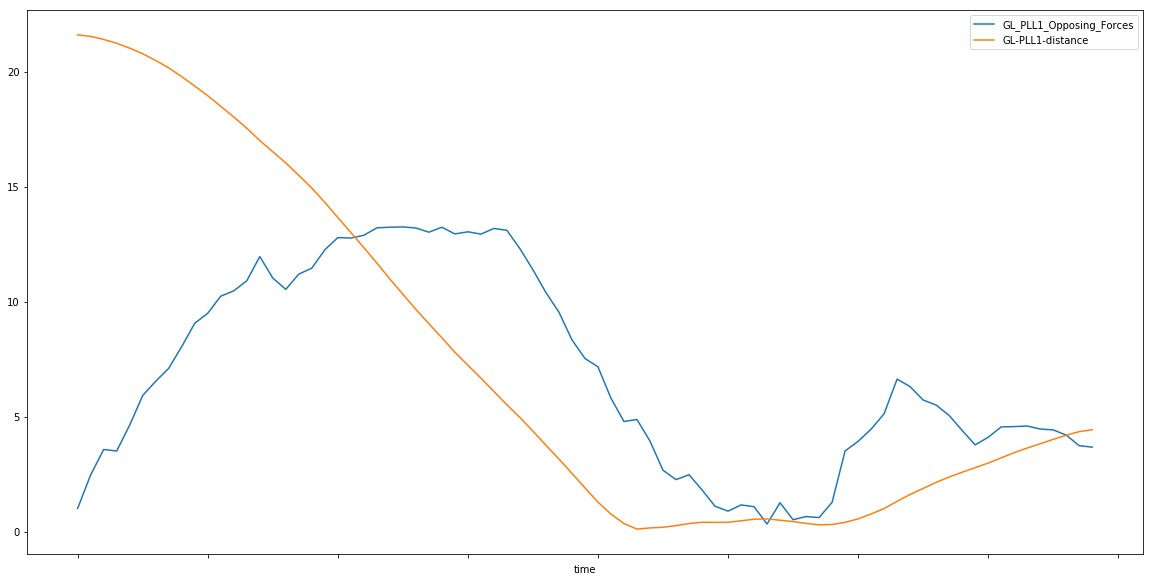

538
time
2016-08-19 23:53:46.500    26.198438
2016-08-19 23:53:46.600    23.244545
2016-08-19 23:53:46.700    21.713738
Name: GR_PR_Opposing_Forces, dtype: float64


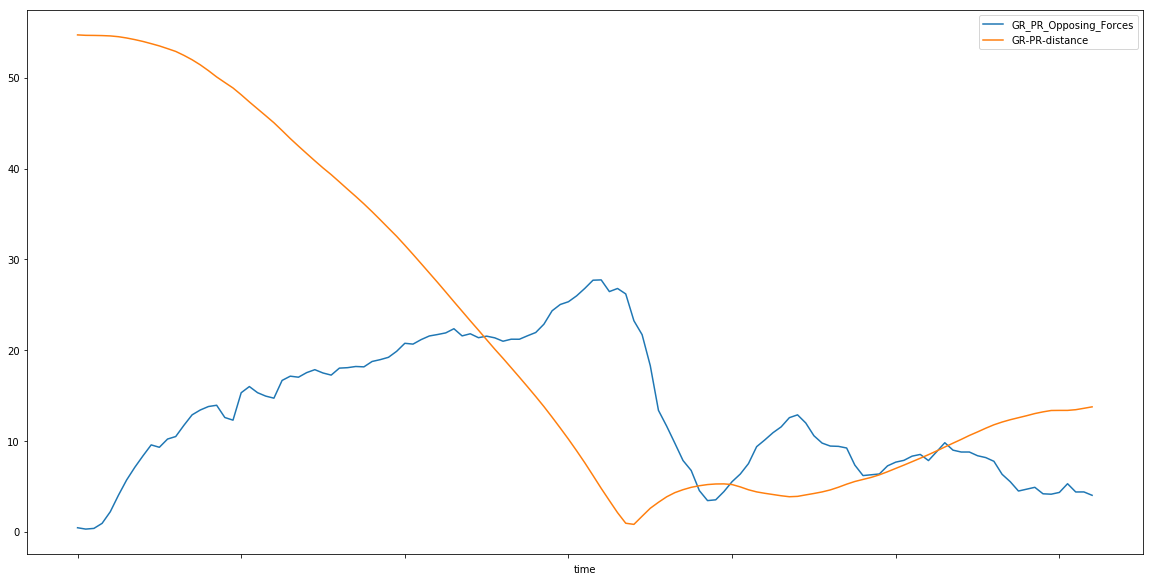

1212
time
2016-08-28 00:28:49.000    8.188139
2016-08-28 00:28:49.100    9.681296
2016-08-28 00:28:49.200    5.364522
2016-08-28 00:28:49.300    4.055455
2016-08-28 00:28:49.400    4.264472
2016-08-28 00:28:49.500    3.660833
2016-08-28 00:28:49.600    2.771591
2016-08-28 00:28:49.700    2.365415
2016-08-28 00:28:49.800    3.529622
2016-08-28 00:28:49.900    0.297554
2016-08-28 00:28:50.000    0.620208
2016-08-28 00:28:50.100    2.039556
Name: PRT_PR_Opposing_Forces, dtype: float64


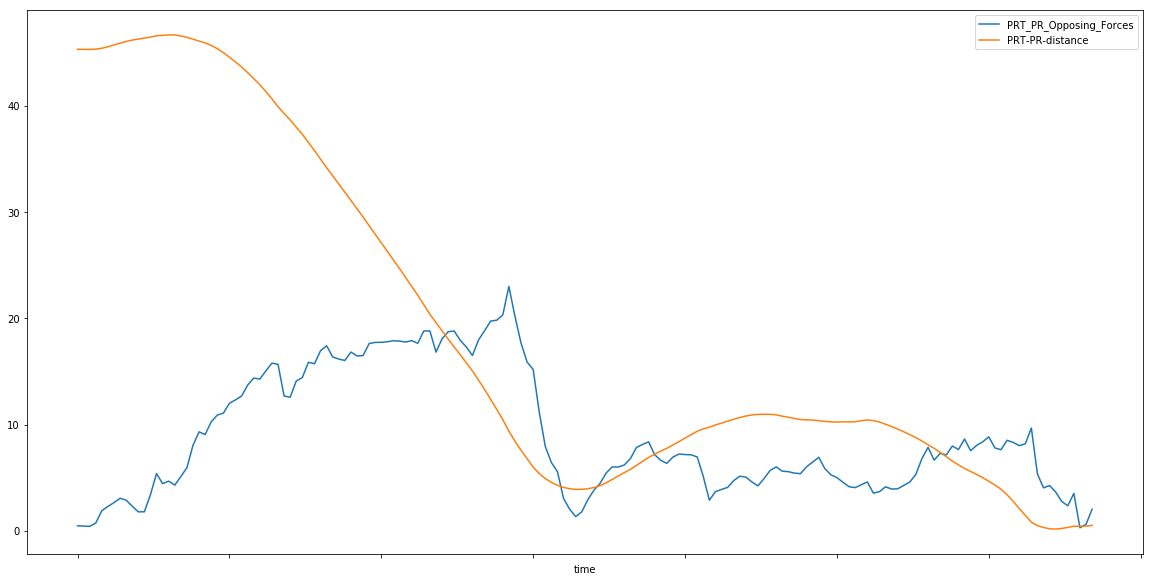

1045
time
2016-09-02 00:33:39.000    12.988598
2016-09-02 00:33:39.100    11.634918
2016-09-02 00:33:39.200    10.414779
2016-09-02 00:33:39.300     9.183696
2016-09-02 00:33:39.400     7.824873
2016-09-02 00:33:39.500     6.637739
2016-09-02 00:33:39.600     6.491043
2016-09-02 00:33:39.700     6.292438
2016-09-02 00:33:39.800     6.398922
2016-09-02 00:33:39.900     4.729832
2016-09-02 00:33:40.000     5.387456
2016-09-02 00:33:40.100     3.493514
2016-09-02 00:33:40.200     3.100121
2016-09-02 00:33:40.300     1.299992
2016-09-02 00:33:40.400     0.502659
2016-09-02 00:33:40.500     1.176716
2016-09-02 00:33:40.600     1.135076
2016-09-02 00:33:40.700     1.098074
2016-09-02 00:33:40.800     1.953486
2016-09-02 00:33:40.900     0.668552
2016-09-02 00:33:41.000     0.752446
2016-09-02 00:33:41.100     1.180762
2016-09-02 00:33:41.200     1.862979
2016-09-02 00:33:41.300     1.092795
2016-09-02 00:33:41.400     1.145128
Name: PRT_GR_Opposing_Forces, dtype: float64


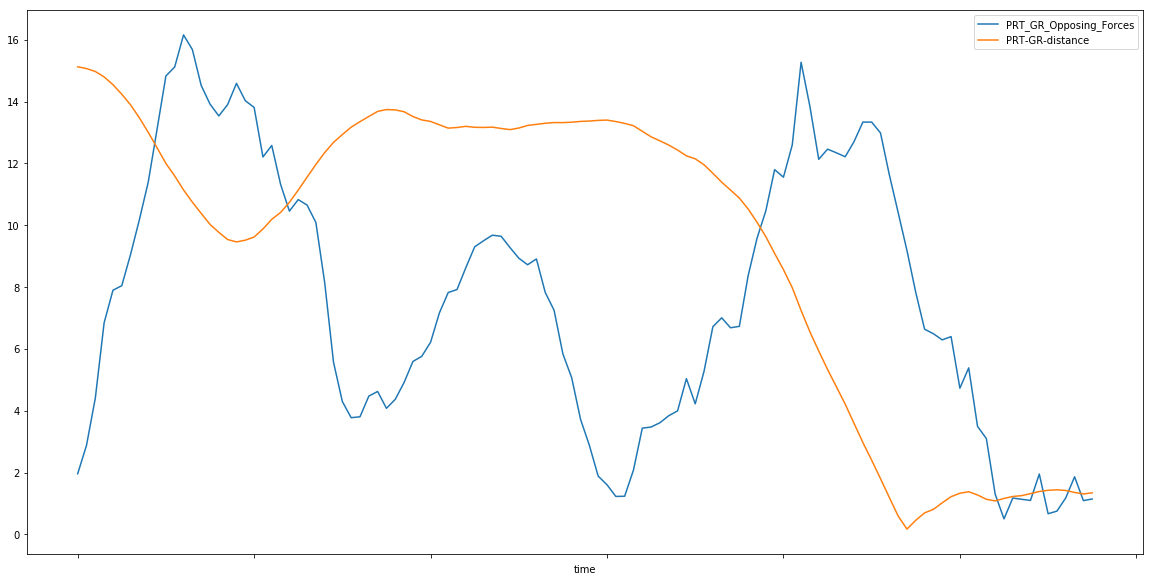

905
time
2016-09-02 00:13:18.500    8.088265
2016-09-02 00:13:18.600    7.816913
2016-09-02 00:13:18.700    7.189643
2016-09-02 00:13:18.800    5.838591
2016-09-02 00:13:18.900    3.884379
2016-09-02 00:13:19.000    3.515373
2016-09-02 00:13:19.100    3.677881
2016-09-02 00:13:19.200    4.446103
2016-09-02 00:13:19.300    3.118797
2016-09-02 00:13:19.400    1.346652
2016-09-02 00:13:19.500    2.454645
2016-09-02 00:13:19.600    1.643892
2016-09-02 00:13:19.700    2.071289
2016-09-02 00:13:19.800    1.114180
2016-09-02 00:13:19.900    0.540594
2016-09-02 00:13:20.000    0.567122
2016-09-02 00:13:20.100    0.902811
2016-09-02 00:13:20.200    1.248237
2016-09-02 00:13:20.300    1.651861
2016-09-02 00:13:20.400    3.078545
2016-09-02 00:13:20.500    3.698670
2016-09-02 00:13:20.600    3.303900
2016-09-02 00:13:20.700    2.518115
2016-09-02 00:13:20.800    1.791816
2016-09-02 00:13:20.900    1.107223
2016-09-02 00:13:21.000    1.589195
2016-09-02 00:13:21.100    1.771605
2016-09-02 00:13:21

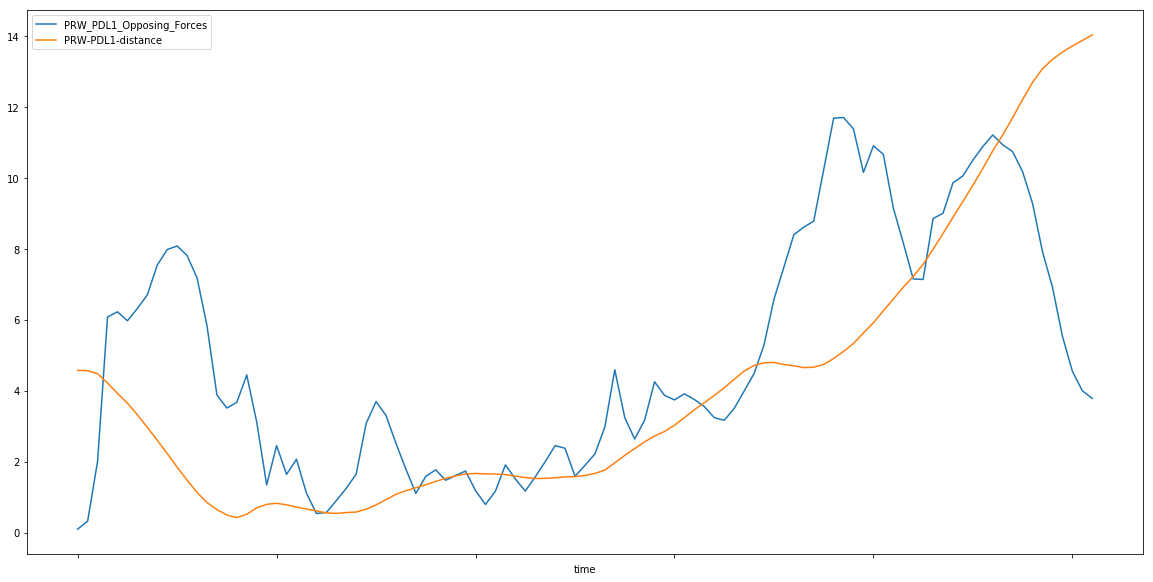

2342
time
2016-10-16 18:46:54.200    12.789537
2016-10-16 18:46:54.300    12.890483
2016-10-16 18:46:54.400    12.159198
2016-10-16 18:46:54.500    12.651281
2016-10-16 18:46:54.600    13.264642
2016-10-16 18:46:54.700    11.033144
2016-10-16 18:46:54.800    10.243023
Name: VR_PLG_Opposing_Forces, dtype: float64


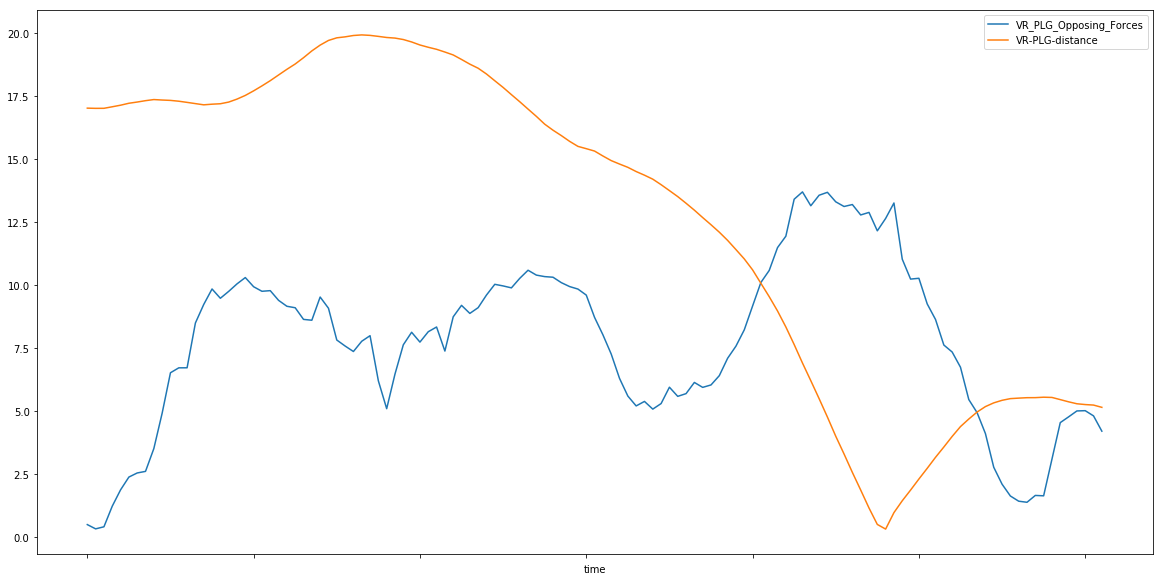

3663
time
2016-10-16 19:38:01.300    13.529966
2016-10-16 19:38:01.400    16.893155
2016-10-16 19:38:01.500    14.378721
2016-10-16 19:38:01.600    10.787906
2016-10-16 19:38:01.700     7.271919
2016-10-16 19:38:01.800     5.573707
2016-10-16 19:38:01.900     4.032273
2016-10-16 19:38:02.000     1.868289
2016-10-16 19:38:02.100     0.412859
2016-10-16 19:38:02.200     0.241979
2016-10-16 19:38:02.300     1.023804
2016-10-16 19:38:02.400     3.886459
2016-10-16 19:38:02.500     3.069196
2016-10-16 19:38:02.600     3.477362
2016-10-16 19:38:02.700     4.516709
2016-10-16 19:38:02.800     3.877473
2016-10-16 19:38:02.900     5.809280
2016-10-16 19:38:03.000     2.724160
2016-10-16 19:38:03.100     2.025551
2016-10-16 19:38:03.200     0.656524
2016-10-16 19:38:03.300     0.594402
2016-10-16 19:38:03.400     0.637059
2016-10-16 19:38:03.500     0.423795
2016-10-16 19:38:03.600     1.331382
2016-10-16 19:38:03.700     1.185763
2016-10-16 19:38:03.800     2.233687
2016-10-16 19:38:03.900     

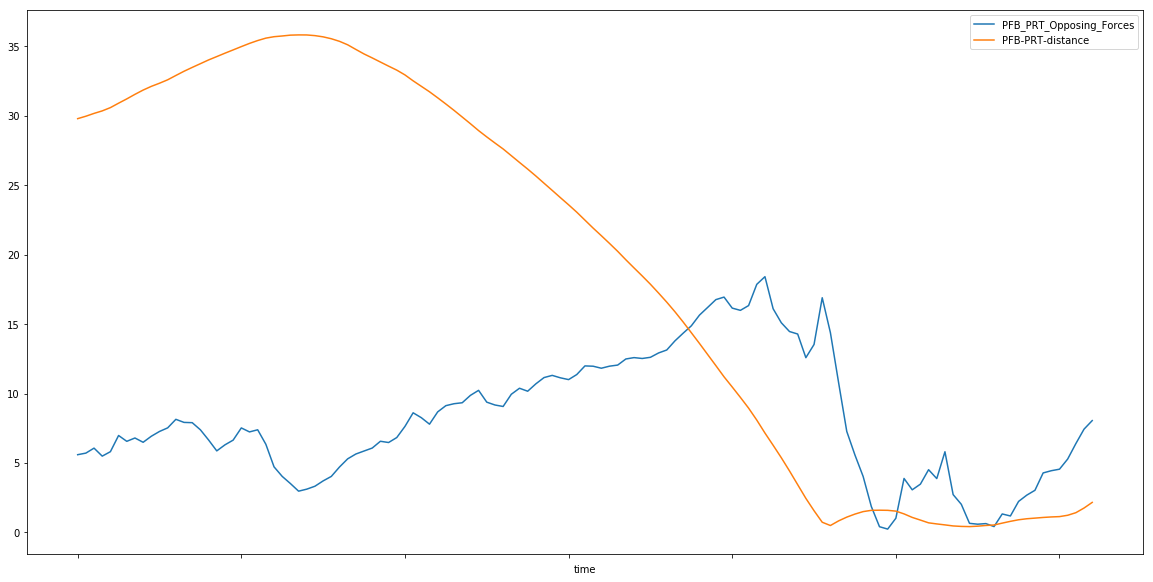

3509
time
2016-11-06 21:00:52.800    26.937349
2016-11-06 21:00:52.900    26.794099
2016-11-06 21:00:53.000    19.524540
Name: PR_PRG_Opposing_Forces, dtype: float64


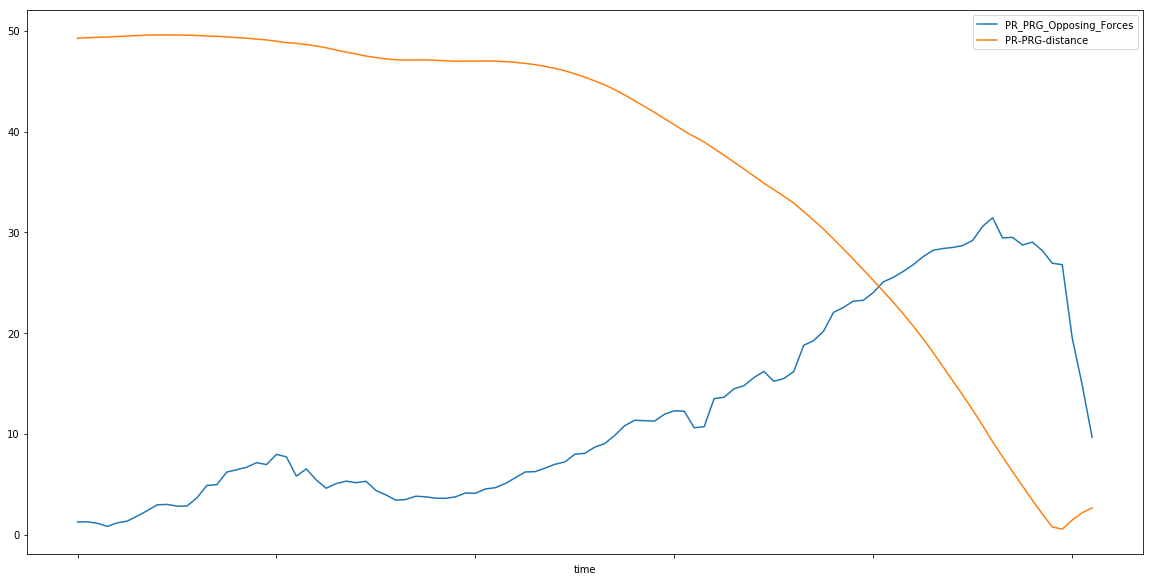

error
1976
time
2016-11-27 19:21:55.300    7.289464
2016-11-27 19:21:55.400    5.886050
2016-11-27 19:21:55.500    4.512012
2016-11-27 19:21:55.600    3.472745
2016-11-27 19:21:55.700    2.431663
2016-11-27 19:21:55.800    1.713180
2016-11-27 19:21:55.900    1.841690
2016-11-27 19:21:56.000    1.648780
2016-11-27 19:21:56.100    3.565180
2016-11-27 19:21:56.200    4.184087
2016-11-27 19:21:56.300    4.943052
2016-11-27 19:21:56.400    5.277889
2016-11-27 19:21:56.500    4.559724
2016-11-27 19:21:56.600    5.627078
Name: PLG_PRW_Opposing_Forces, dtype: float64


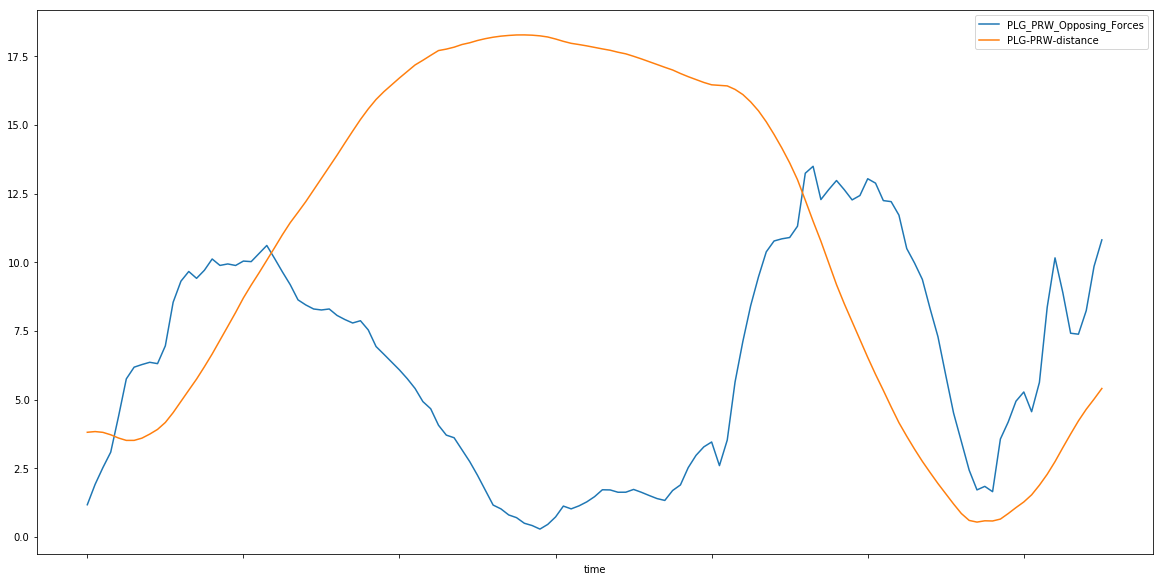

3278
Series([], Name: PRG_PR_Opposing_Forces, dtype: float64)


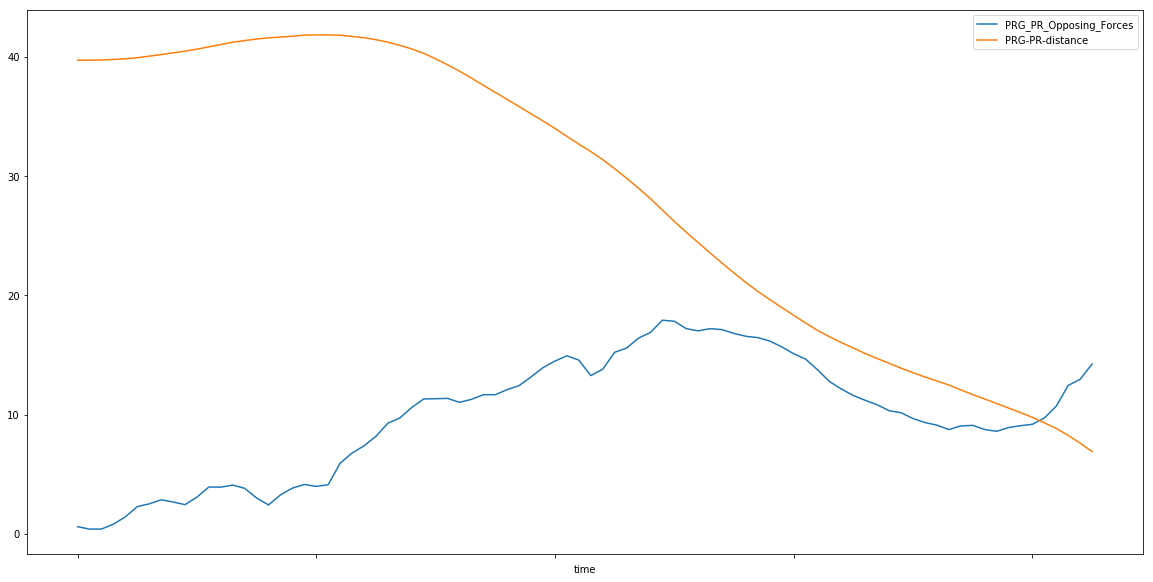

2902
time
2016-12-11 20:30:37.700    22.908996
2016-12-11 20:30:37.800    18.612875
2016-12-11 20:30:37.900    14.317931
2016-12-11 20:30:38.000    15.133394
Name: PR_GR_Opposing_Forces, dtype: float64


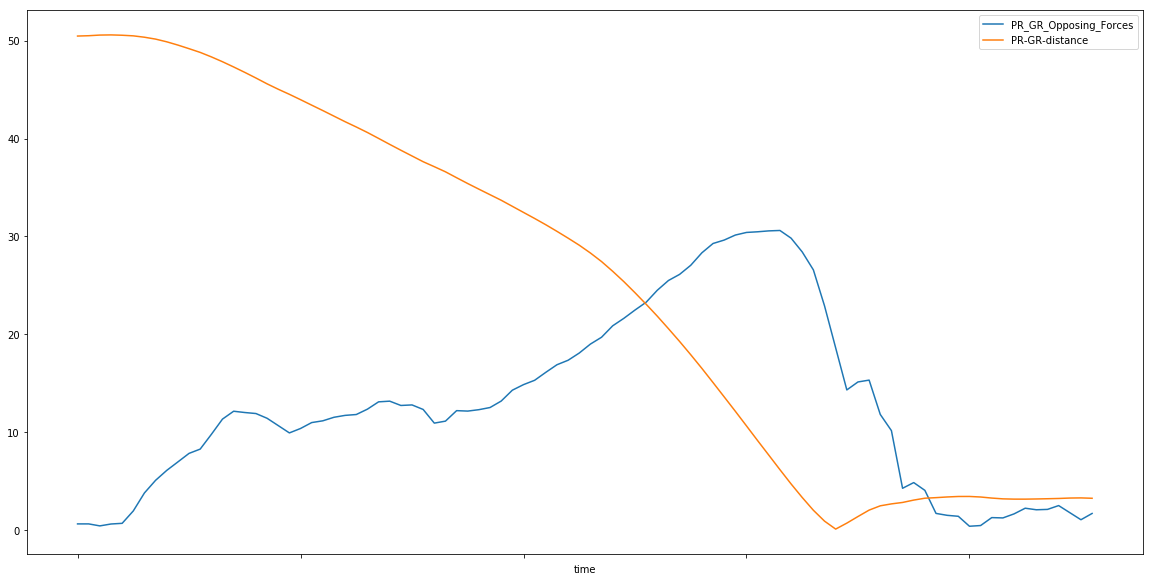

3609
time
2016-12-16 04:19:02.600    15.052077
2016-12-16 04:19:02.700    14.421955
2016-12-16 04:19:02.800    13.260291
Name: P_VLo_Opposing_Forces, dtype: float64


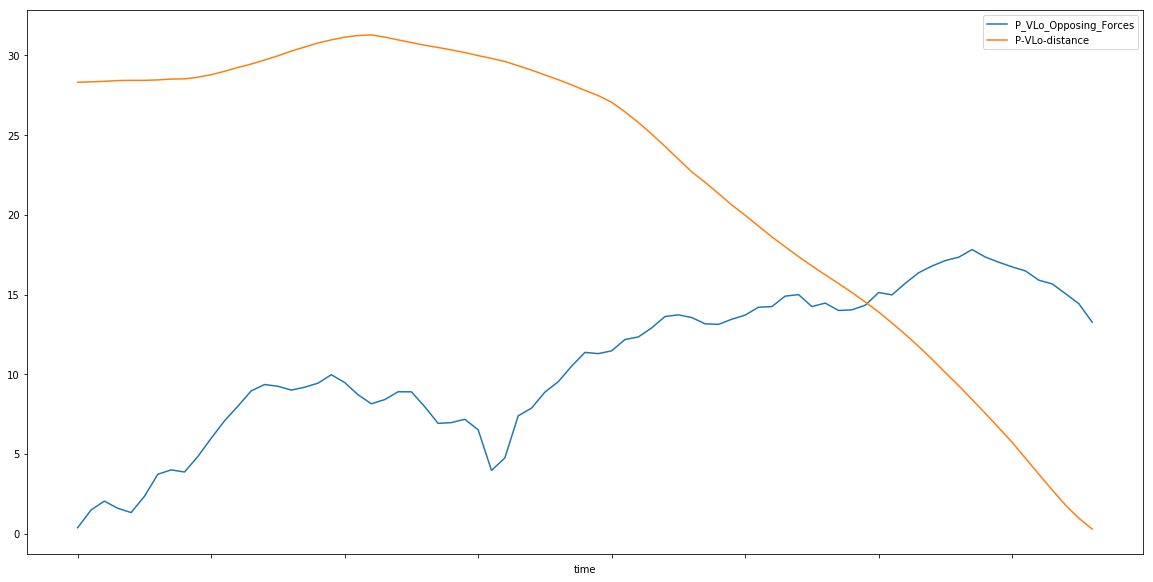

2918
time
2016-12-18 20:20:51.200     7.882043
2016-12-18 20:20:51.300     9.825325
2016-12-18 20:20:51.400    10.602675
2016-12-18 20:20:51.500    11.579283
2016-12-18 20:20:51.600    12.142327
2016-12-18 20:20:51.700    11.754198
2016-12-18 20:20:51.800    10.670207
2016-12-18 20:20:51.900     9.635147
2016-12-18 20:20:55.000     8.328874
2016-12-18 20:20:55.100     9.257424
Name: PLW_PDR1_Opposing_Forces, dtype: float64


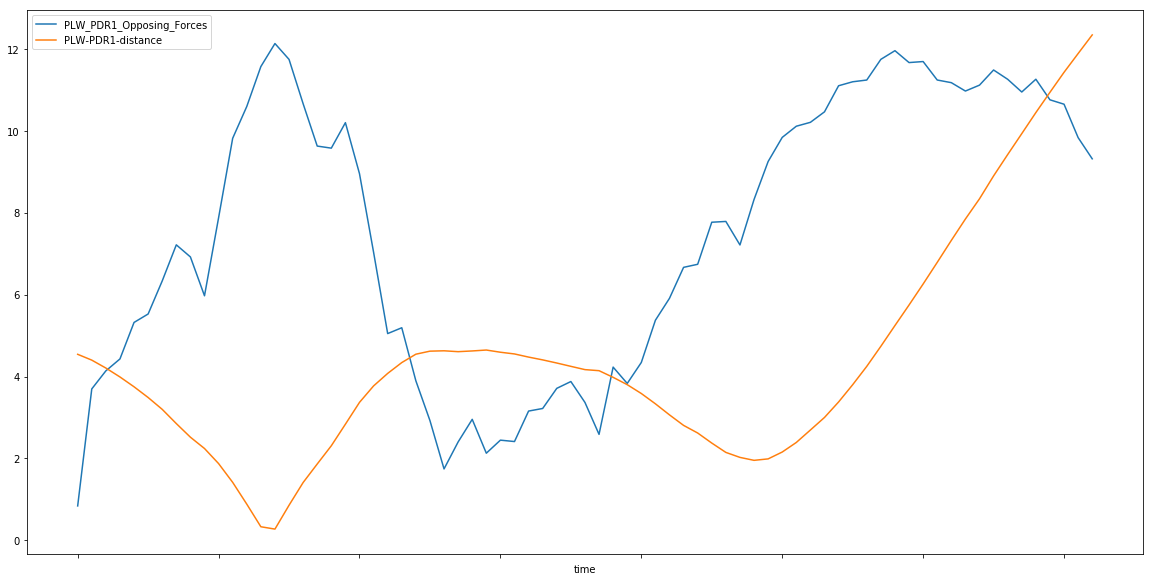

3746
time
2016-12-18 20:55:48.300    13.364455
2016-12-18 20:55:48.400    12.490679
2016-12-18 20:55:48.500    11.340553
2016-12-18 20:55:48.600    10.421095
2016-12-18 20:55:48.700     7.689680
2016-12-18 20:55:48.800     4.765304
2016-12-18 20:55:48.900     3.931867
2016-12-18 20:55:49.000     3.226173
2016-12-18 20:55:49.100     3.357423
2016-12-18 20:55:49.200     2.908051
2016-12-18 20:55:49.300     3.484269
Name: GL_PR_Opposing_Forces, dtype: float64


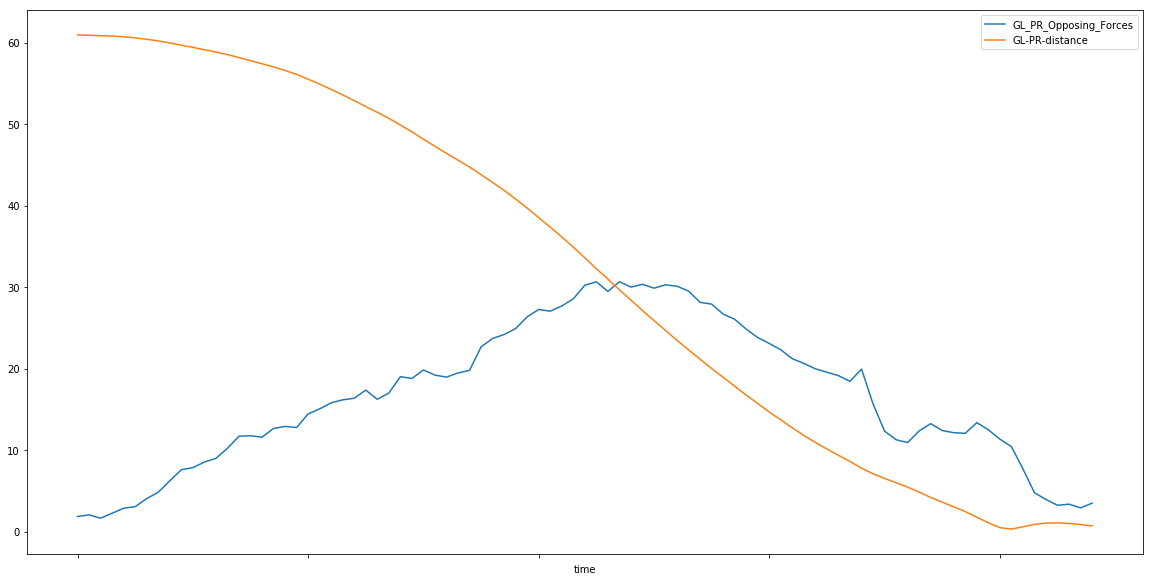

1526
time
2016-12-18 19:16:07.800    19.033039
Name: PLG_PLW_Opposing_Forces, dtype: float64


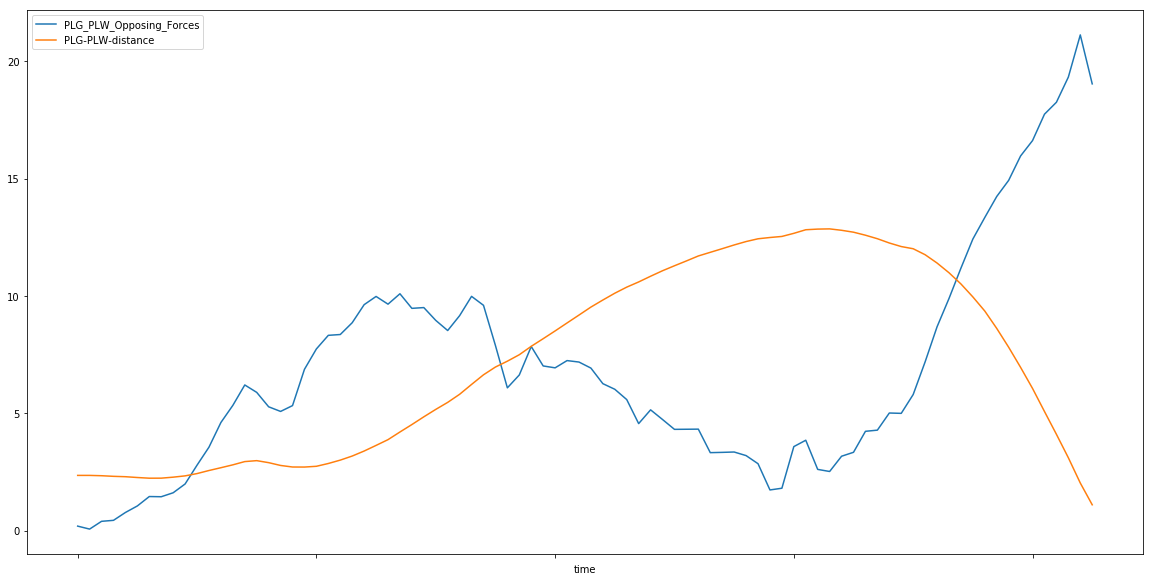

2341
time
2016-12-20 03:19:55.000    15.711643
2016-12-20 03:19:55.100    14.504038
2016-12-20 03:19:55.200    12.901127
2016-12-20 03:19:55.300    12.277850
2016-12-20 03:19:55.400    11.837146
2016-12-20 03:19:55.500    12.398112
Name: GL_PDR3_Opposing_Forces, dtype: float64


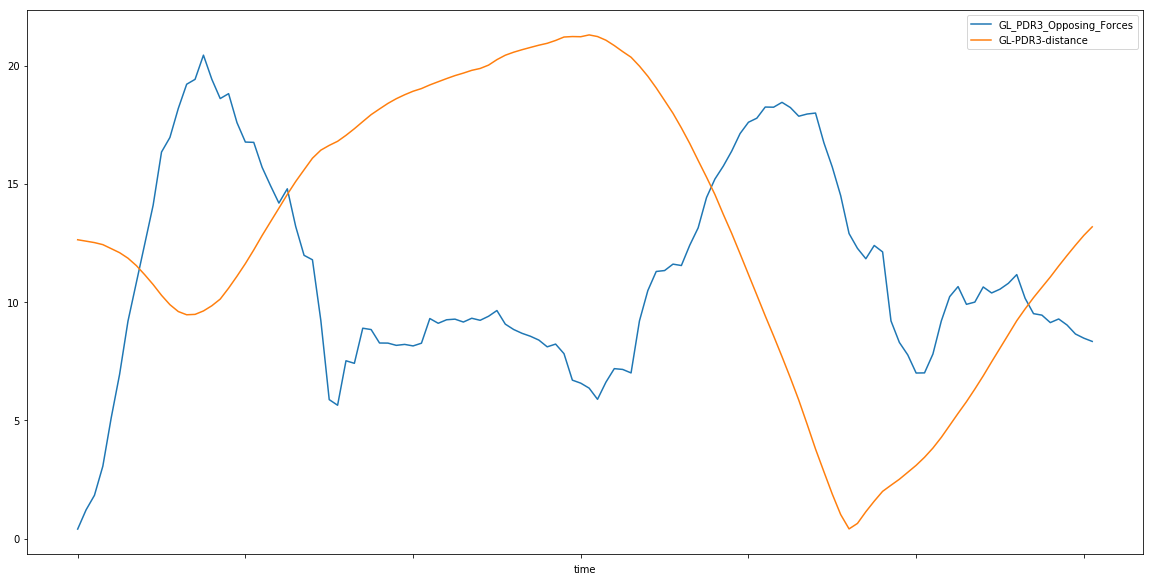

2667
time
2016-12-24 19:59:48.100    17.138479
2016-12-24 19:59:48.200    14.112285
2016-12-24 19:59:48.300    12.233136
2016-12-24 19:59:48.400    11.343926
2016-12-24 19:59:48.500    11.063538
Name: GL_GR_Opposing_Forces, dtype: float64


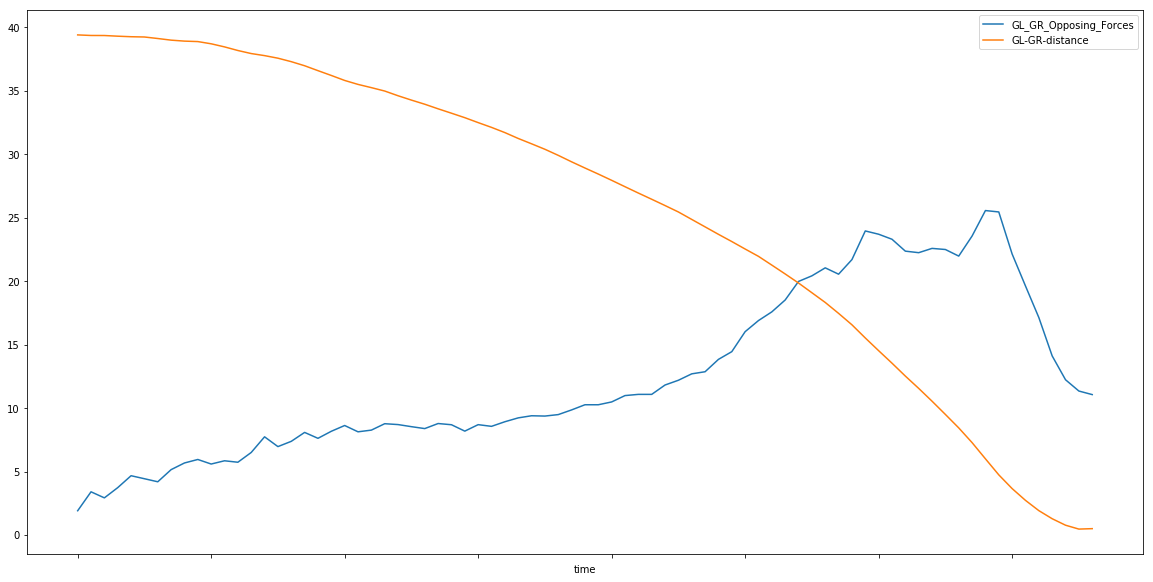

3630
time
2017-08-18 01:39:14.800    15.617679
2017-08-18 01:39:14.900    11.671066
2017-08-18 01:39:15.000     9.647229
2017-08-18 01:39:15.100     8.537196
2017-08-18 01:39:15.200     6.708622
2017-08-18 01:39:15.300     6.315857
2017-08-18 01:39:15.400     6.245918
Name: PRG_PR_Opposing_Forces, dtype: float64


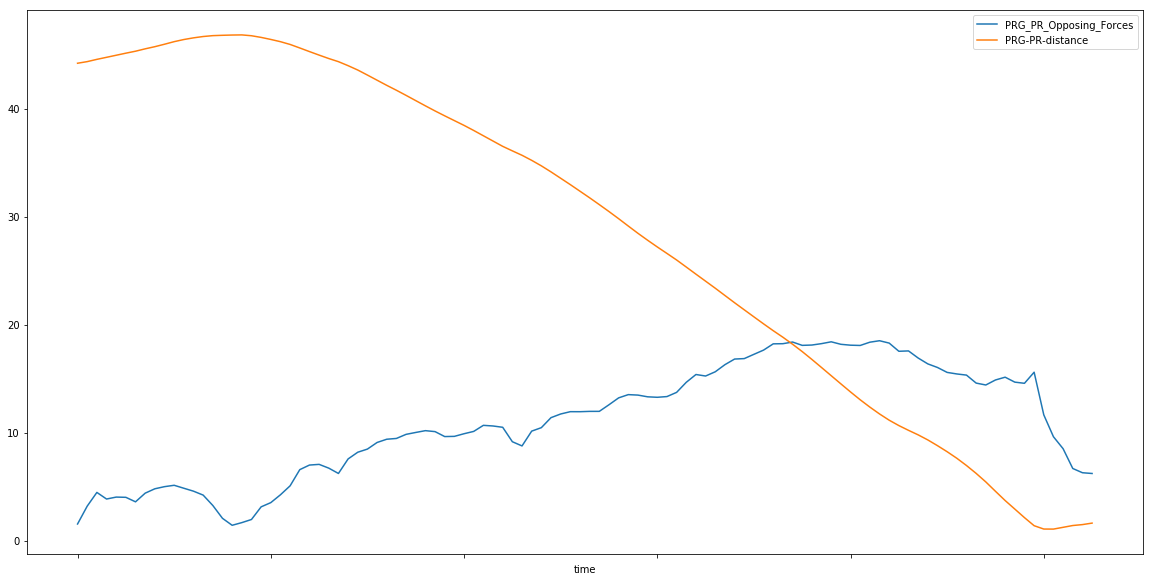

2489
time
2017-08-20 01:29:11.200    1.736888
2017-08-20 01:29:11.300    3.011101
2017-08-20 01:29:11.400    3.823041
2017-08-20 01:29:11.500    4.208031
2017-08-20 01:29:11.600    5.328426
2017-08-20 01:29:11.700    5.757016
2017-08-20 01:29:11.800    4.664906
2017-08-20 01:29:11.900    4.083347
2017-08-20 01:29:12.000    3.376764
2017-08-20 01:29:12.100    2.598023
2017-08-20 01:29:12.200    1.809929
2017-08-20 01:29:12.300    1.986818
2017-08-20 01:29:12.400    2.012335
2017-08-20 01:29:12.500    1.078277
2017-08-20 01:29:12.600    1.227436
2017-08-20 01:29:12.700    1.261409
2017-08-20 01:29:12.800    0.946575
2017-08-20 01:29:12.900    0.686430
2017-08-20 01:29:13.000    0.912466
2017-08-20 01:29:13.100    0.736769
2017-08-20 01:29:13.200    1.463030
2017-08-20 01:29:13.300    1.655047
2017-08-20 01:29:13.400    2.579444
2017-08-20 01:29:13.500    2.552288
2017-08-20 01:29:13.600    2.430511
2017-08-20 01:29:13.700    1.891482
2017-08-20 01:29:13.800    1.911647
2017-08-20 01:29:1

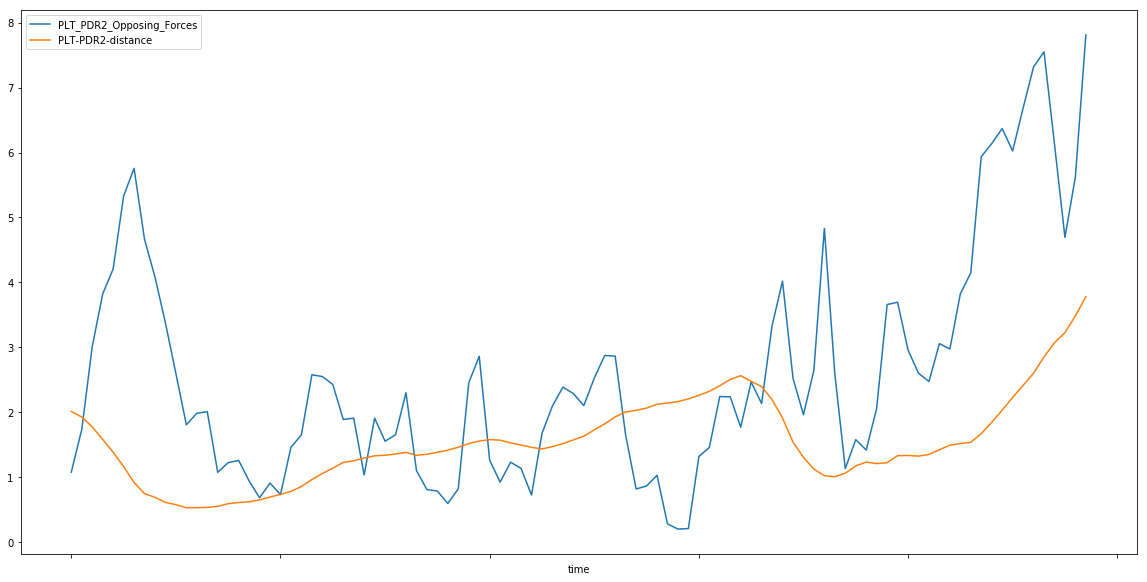

2764
time
2017-08-20 01:42:35.900    9.330047
2017-08-20 01:42:36.000    9.183341
2017-08-20 01:42:36.100    7.835535
2017-08-20 01:42:36.200    5.401065
2017-08-20 01:42:36.300    4.226593
2017-08-20 01:42:36.400    3.544633
2017-08-20 01:42:36.500    2.910721
2017-08-20 01:42:36.600    2.786358
Name: PLG_PDR1_Opposing_Forces, dtype: float64


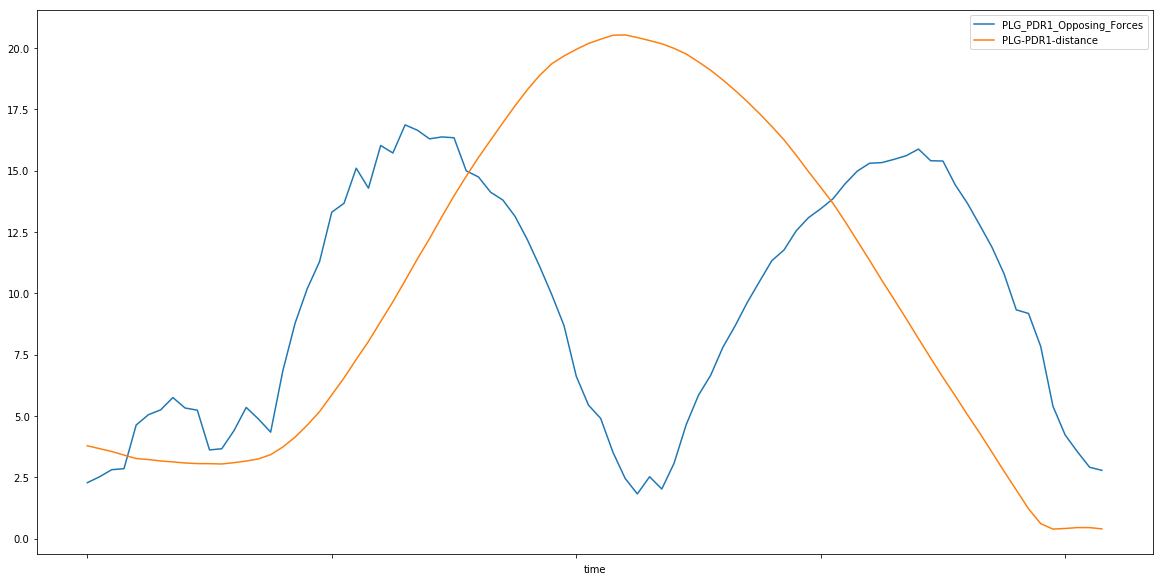

183
Series([], Name: PPR_PLT_Opposing_Forces, dtype: float64)


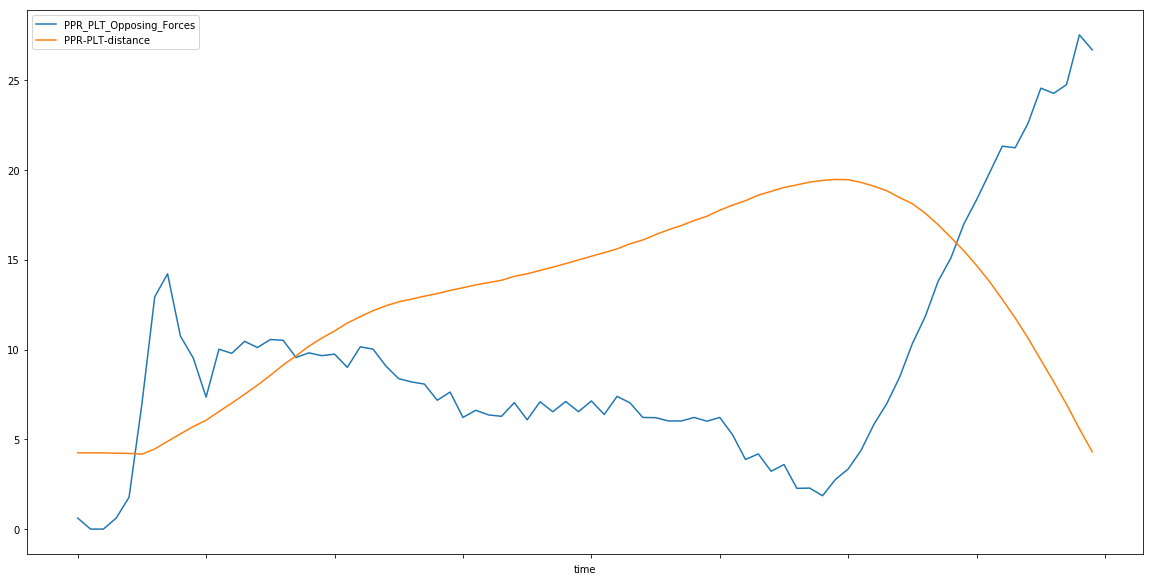

1088
time
2017-09-01 01:24:07.100    10.465354
2017-09-01 01:24:07.200     6.745742
2017-09-01 01:24:07.300     4.966826
2017-09-01 01:24:07.400     3.663546
2017-09-01 01:24:07.500     1.816962
2017-09-01 01:24:07.600     0.703460
2017-09-01 01:24:07.700     2.888357
Name: PLS_PDL1_Opposing_Forces, dtype: float64


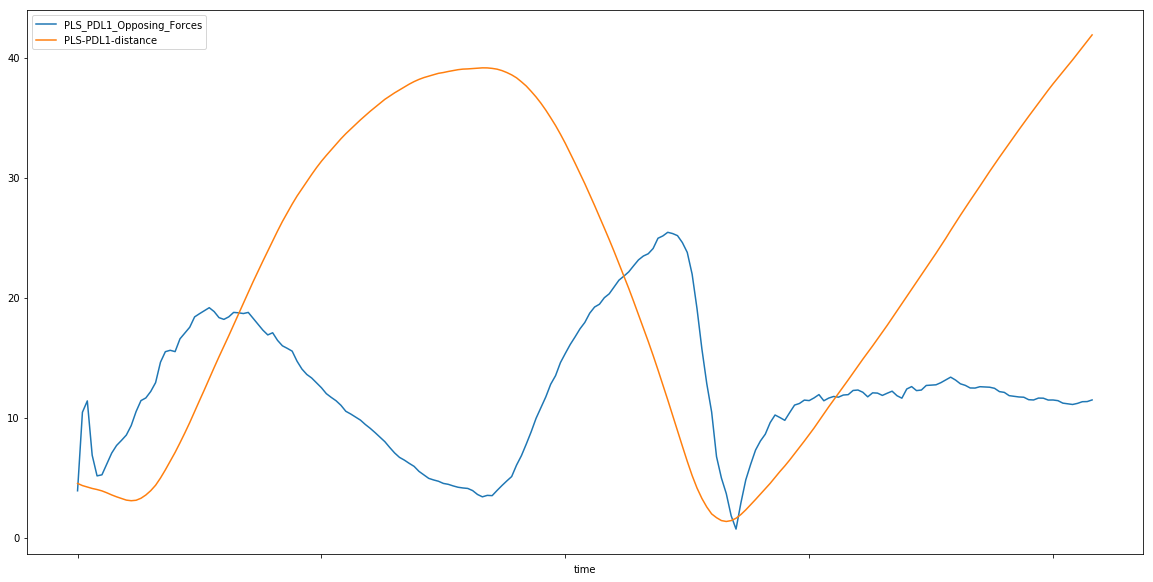

1526
time
2017-09-01 03:10:23.400    14.266783
2017-09-01 03:10:23.500    11.856327
2017-09-01 03:10:23.600    10.711836
2017-09-01 03:10:23.700     9.468363
2017-09-01 03:10:23.800     9.694309
2017-09-01 03:10:23.900     9.276199
2017-09-01 03:10:24.000     9.126183
2017-09-01 03:10:24.100     9.313749
2017-09-01 03:10:24.200     3.999100
2017-09-01 03:10:24.300     2.610770
2017-09-01 03:10:24.400     2.670736
Name: PLT_PR_Opposing_Forces, dtype: float64


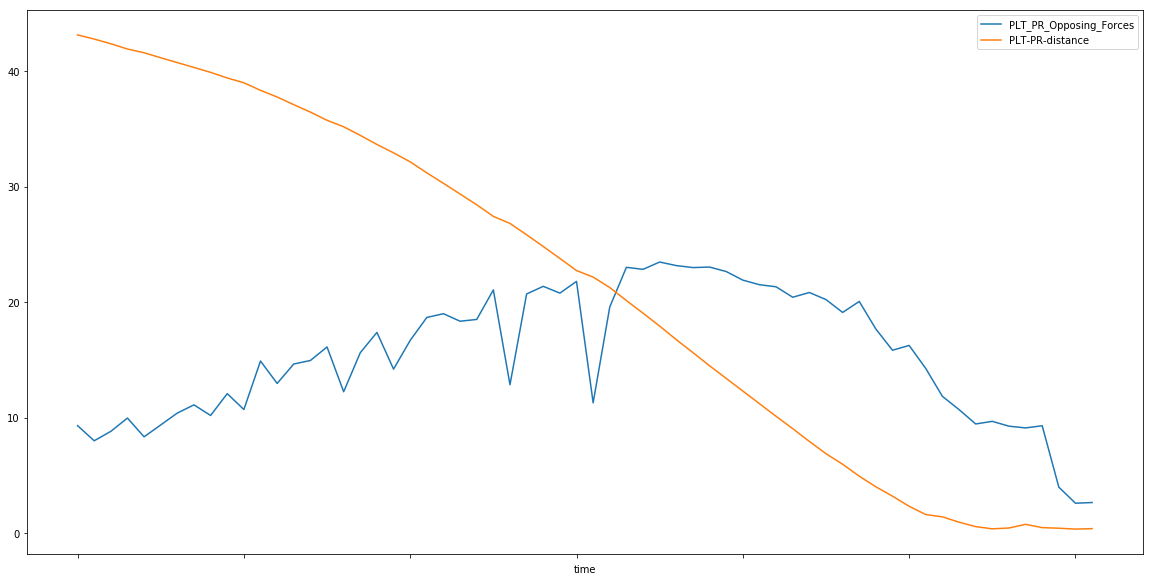

3312
time
2017-09-08 03:10:57.000    14.099426
2017-09-08 03:10:57.100    12.823018
2017-09-08 03:10:57.200    11.879491
2017-09-08 03:10:57.300    10.320628
Name: PR_PRT_Opposing_Forces, dtype: float64


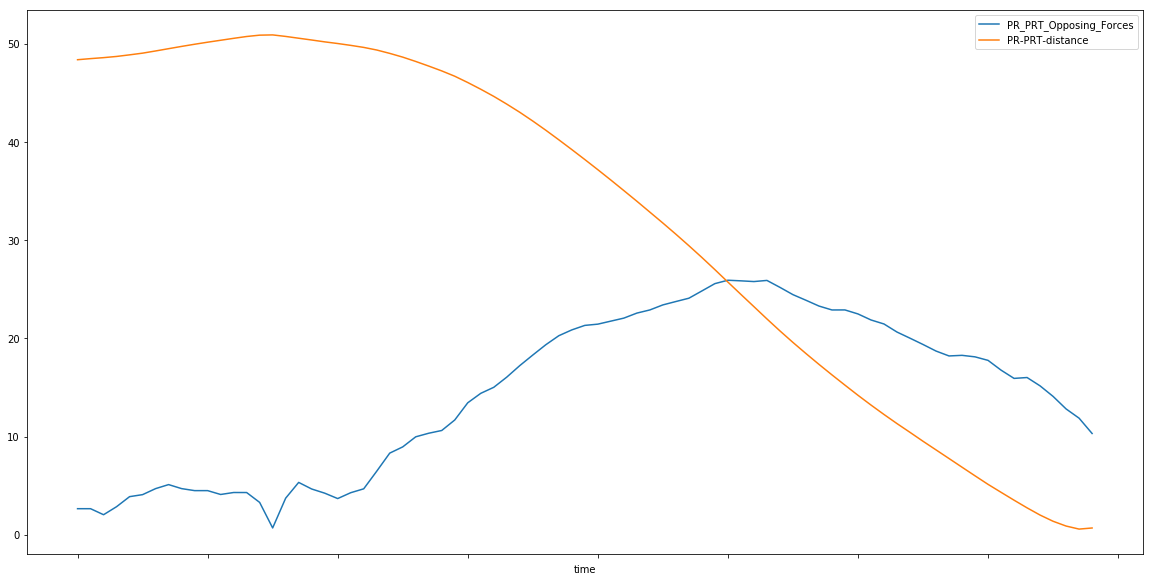

error
2792
time
2017-10-01 15:39:58.200    14.103155
Name: PDR1_PRG_Opposing_Forces, dtype: float64


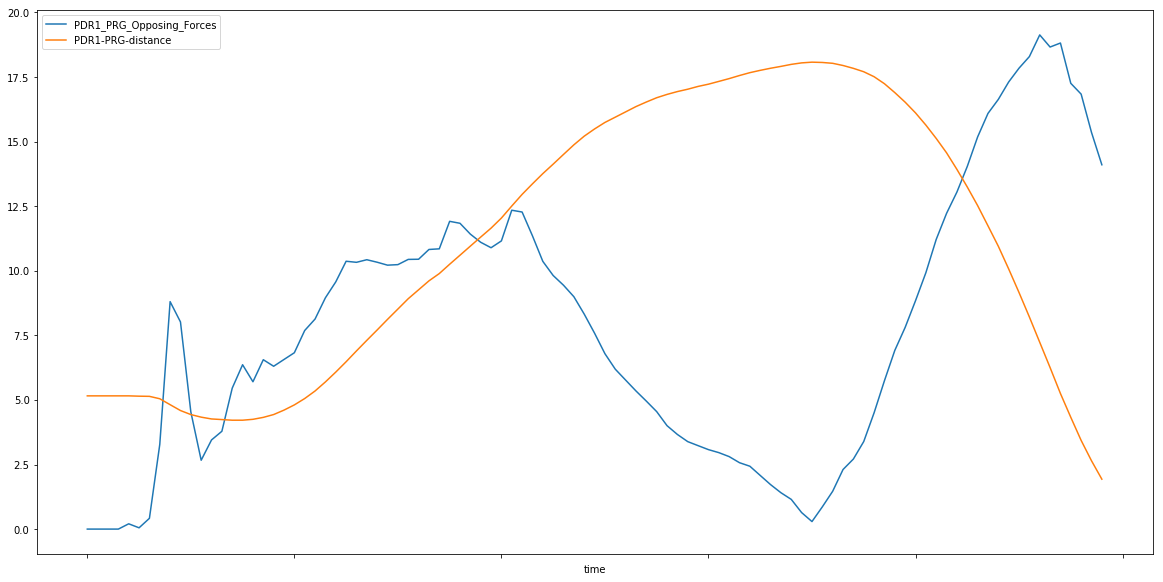

2072
time
2017-10-08 21:48:30.400    9.117619
2017-10-08 21:48:30.500    9.315197
2017-10-08 21:48:30.600    7.414420
2017-10-08 21:48:30.700    6.257015
2017-10-08 21:48:30.800    4.693065
2017-10-08 21:48:30.900    3.948675
2017-10-08 21:48:31.000    3.514551
2017-10-08 21:48:31.100    3.451958
2017-10-08 21:48:31.200    3.626259
2017-10-08 21:48:31.300    3.117847
2017-10-08 21:48:31.400    2.875455
2017-10-08 21:48:31.500    1.865812
2017-10-08 21:48:31.600    2.100454
2017-10-08 21:48:31.700    1.985711
2017-10-08 21:48:31.800    2.452808
2017-10-08 21:48:31.900    2.113244
2017-10-08 21:48:32.000    2.587817
2017-10-08 21:48:32.100    2.489591
2017-10-08 21:48:32.200    2.572673
2017-10-08 21:48:32.300    1.885028
2017-10-08 21:48:32.400    2.739689
2017-10-08 21:48:32.500    1.836357
2017-10-08 21:48:32.600    1.368796
Name: PRG_PLT_Opposing_Forces, dtype: float64


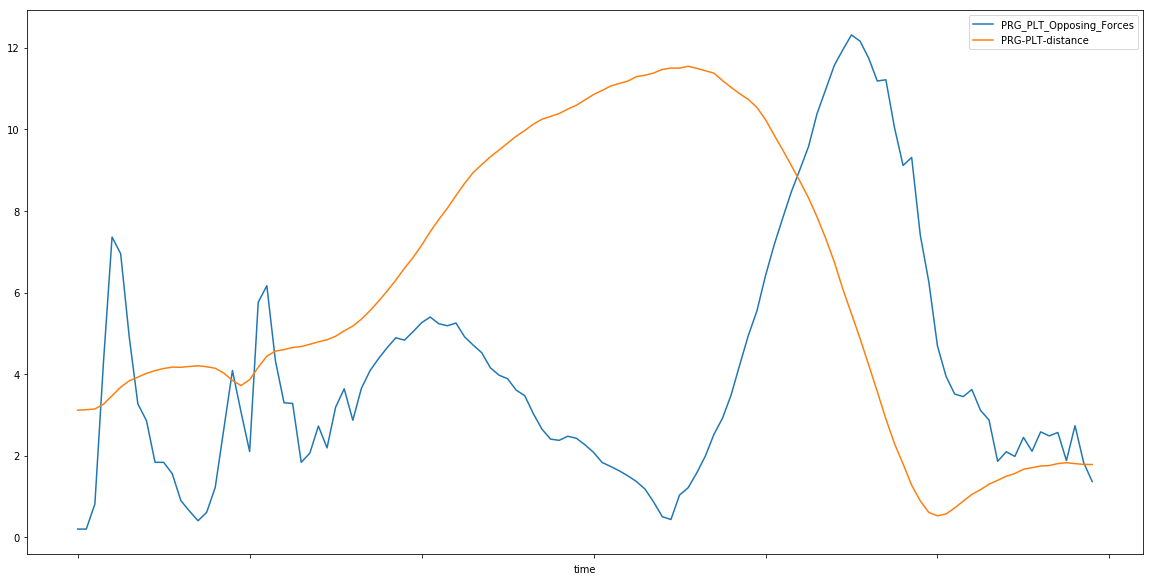

error
1683
time
2017-11-19 19:16:12.800     7.288276
2017-11-19 19:16:12.900     7.259926
2017-11-19 19:16:21.400    15.313273
2017-11-19 19:16:21.500    13.801946
2017-11-19 19:16:21.600    13.020619
2017-11-19 19:16:21.700    10.367821
2017-11-19 19:16:21.800     9.514196
2017-11-19 19:16:21.900     7.381956
2017-11-19 19:16:22.000     5.606375
2017-11-19 19:16:22.100     5.516067
2017-11-19 19:16:22.200     5.019791
2017-11-19 19:16:22.300     4.207595
2017-11-19 19:16:22.400     4.216789
Name: PDL2_PLS_Opposing_Forces, dtype: float64


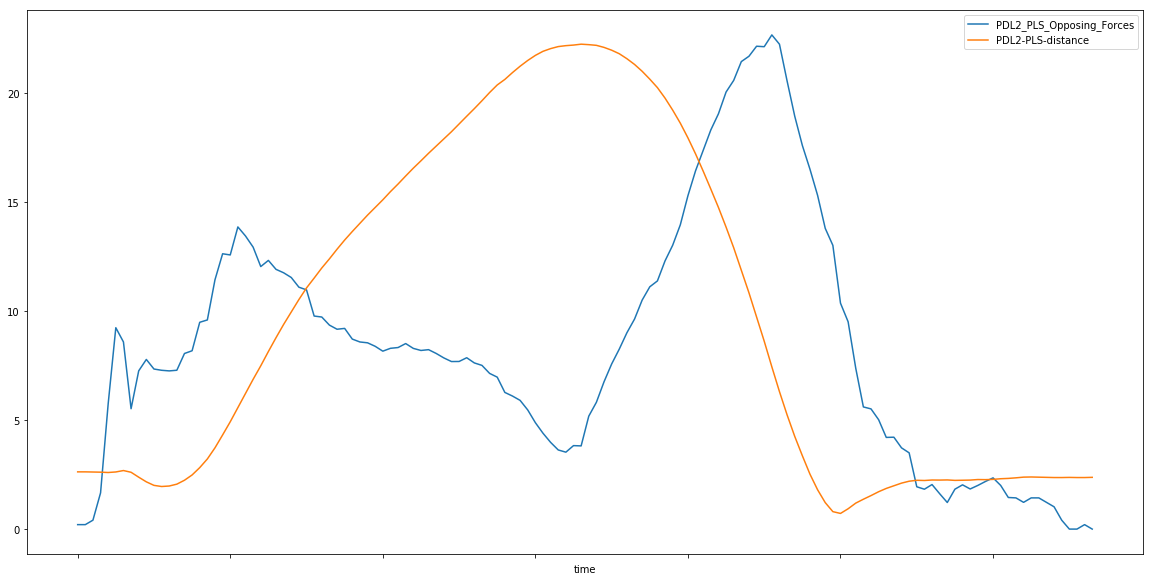

1407
time
2017-11-26 18:59:23.500     8.305429
2017-11-26 18:59:23.600     9.087748
2017-11-26 18:59:23.700     9.665546
2017-11-26 18:59:23.800    10.513216
2017-11-26 18:59:23.900    11.009763
2017-11-26 18:59:24.000    11.354463
2017-11-26 18:59:24.100    11.942024
2017-11-26 18:59:24.200    12.567976
Name: PLL_GR_Opposing_Forces, dtype: float64


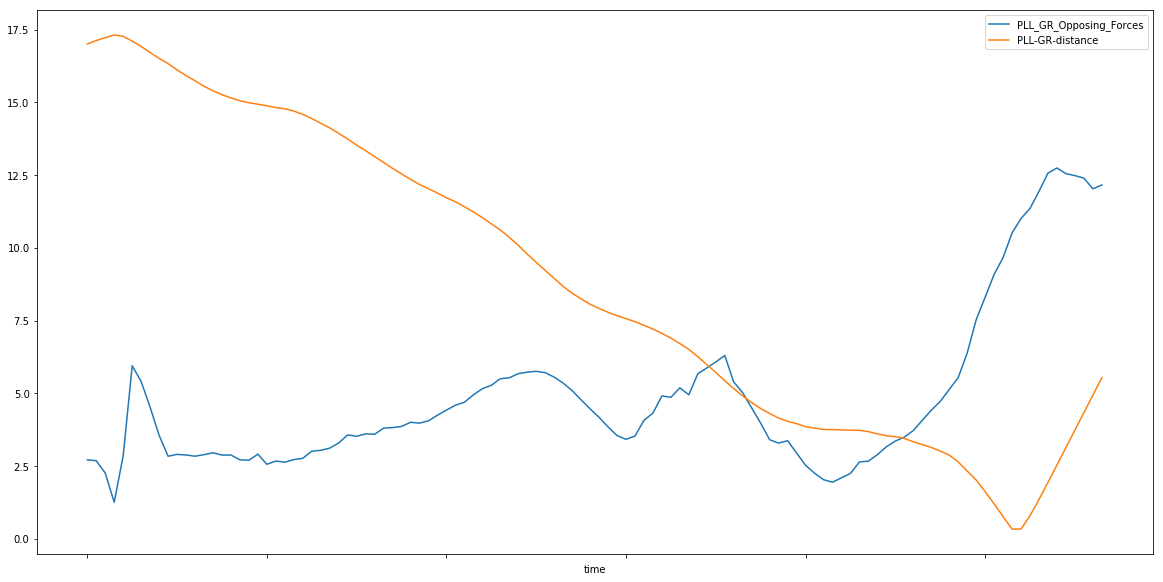

2208
Series([], Name: PR_PPR_Opposing_Forces, dtype: float64)


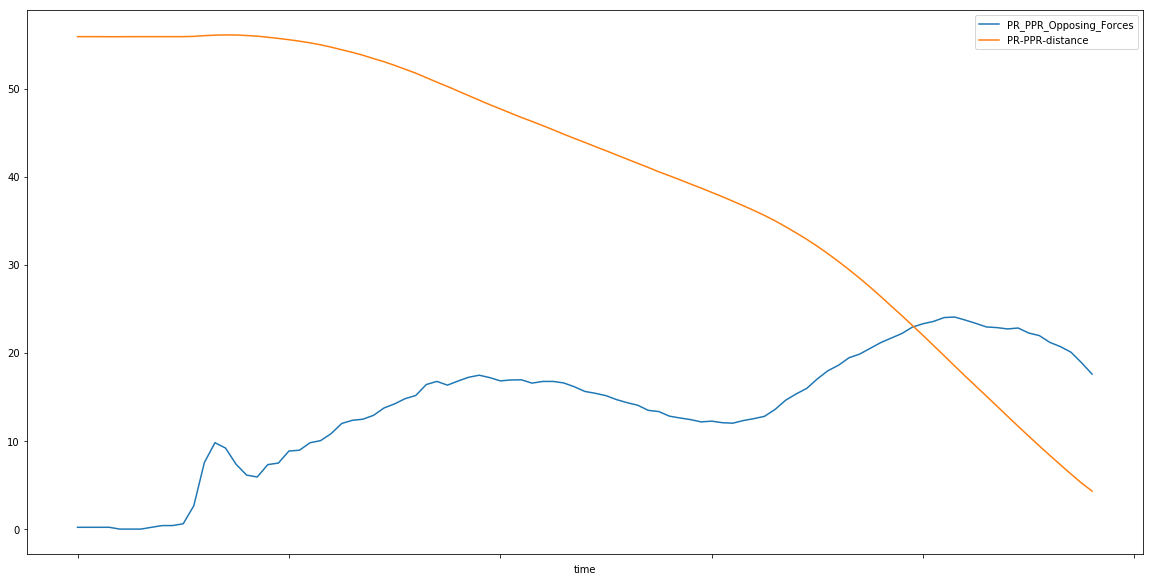

error
602
time
2017-12-10 21:27:21.000    10.327398
2017-12-10 21:27:21.100     9.709355
2017-12-10 21:27:21.200     8.842603
2017-12-10 21:27:21.300     7.208111
2017-12-10 21:27:21.400     4.993578
2017-12-10 21:27:21.500     4.358799
2017-12-10 21:27:21.600     2.423620
2017-12-10 21:27:21.700     1.641429
2017-12-10 21:27:21.800     0.632972
2017-12-10 21:27:21.900     1.863942
Name: PLS_PR_Opposing_Forces, dtype: float64


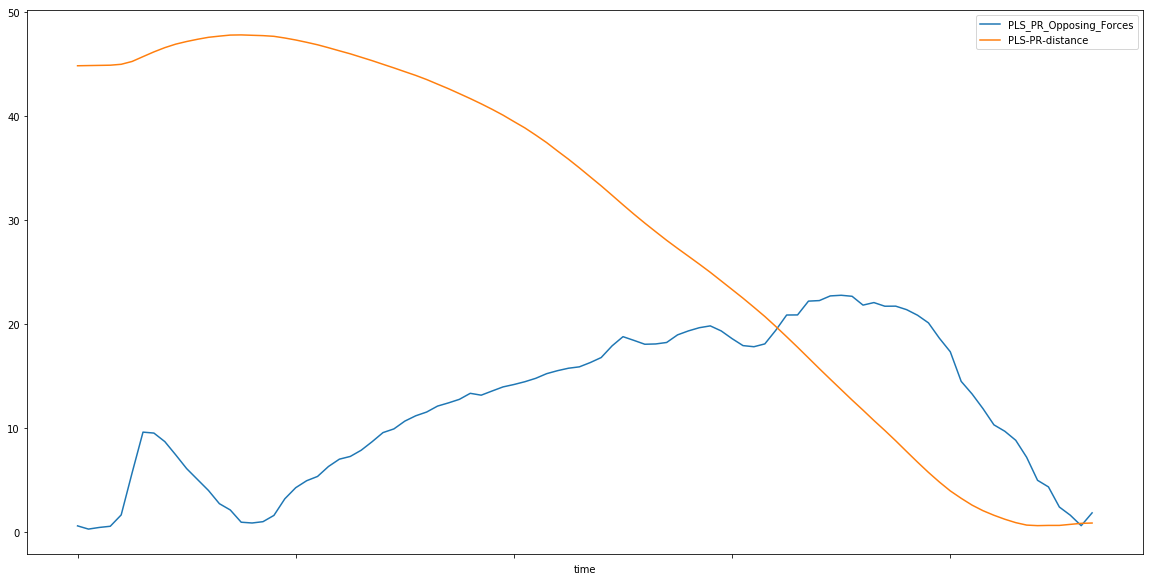

978
time
2017-12-15 02:03:14.100    5.732178
2017-12-15 02:03:14.200    5.322287
2017-12-15 02:03:14.300    4.708056
2017-12-15 02:03:14.400    3.477453
2017-12-15 02:03:14.500    3.071047
2017-12-15 02:03:14.600    2.873876
2017-12-15 02:03:14.700    1.664380
2017-12-15 02:03:14.800    1.262423
2017-12-15 02:03:14.900    0.229827
2017-12-15 02:03:15.000    0.100388
2017-12-15 02:03:15.100    0.205548
2017-12-15 02:03:15.200    0.458627
2017-12-15 02:03:15.300    0.393511
2017-12-15 02:03:15.400    0.760367
2017-12-15 02:03:15.500    1.005233
2017-12-15 02:03:15.600    2.343923
2017-12-15 02:03:15.700    1.692985
2017-12-15 02:03:15.800    1.689713
2017-12-15 02:03:15.900    2.250631
2017-12-15 02:03:16.000    1.739002
2017-12-15 02:03:16.100    1.413001
2017-12-15 02:03:16.200    1.268070
2017-12-15 02:03:16.300    0.972391
2017-12-15 02:03:16.400    0.690082
2017-12-15 02:03:16.500    1.170299
2017-12-15 02:03:16.600    1.280341
2017-12-15 02:03:16.700    1.938237
2017-12-15 02:03:16

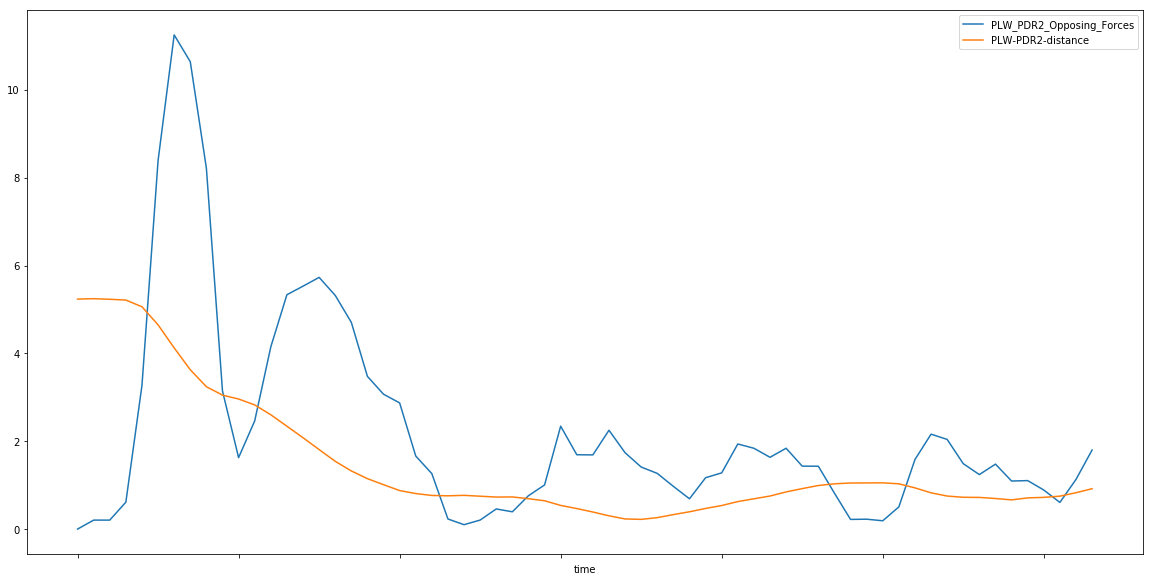

2792
time
2017-12-17 23:13:35.400    12.399800
2017-12-17 23:13:35.500    12.486750
2017-12-17 23:13:35.600     9.699057
2017-12-17 23:13:35.700     8.943097
2017-12-17 23:13:35.800     7.824264
2017-12-17 23:13:35.900     5.887063
2017-12-17 23:13:36.000     5.336409
2017-12-17 23:13:36.100     3.403427
Name: PRG_PDR1_Opposing_Forces, dtype: float64


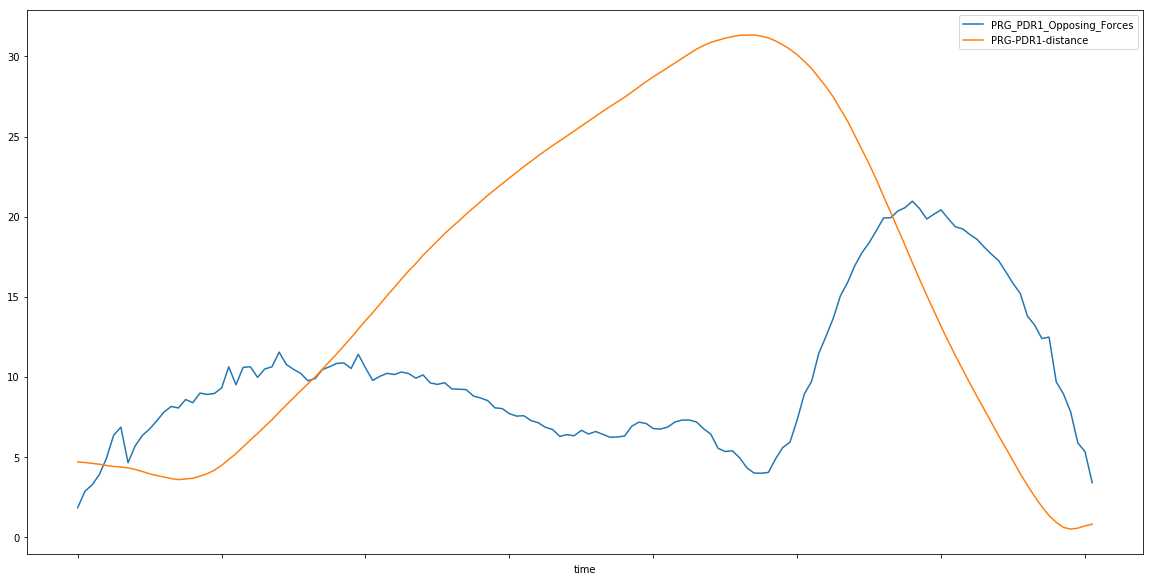

In [244]:
for row in vr_merged.iterrows():
    role1 = row[1]['Role_x']
    role2 = row[1]['Role_y']
    year = row[1]['Season_Year']
    gamekey = row[1]['GameKey']
    playid = row[1]['PlayID']
    try:
        df = plot_opposing_forces(year, gamekey, playid, role1, role2)
        print(playid)
        print(df.loc[df['{}-{}-distance'.format(role1, role2)] < 2]['{}_{}_Opposing_Forces'.format(role1, role2)])
        plt.show()
    except:
        print('error')

time
2017-12-17 23:13:35.600    9.699057
2017-12-17 23:13:35.700    8.943097
2017-12-17 23:13:35.800    7.824264
2017-12-17 23:13:35.900    5.887063
2017-12-17 23:13:36.000    5.336409
2017-12-17 23:13:36.100    3.403427
Name: PRG_PDR1_Opposing_Forces, dtype: float64